# Машинное обучение, ФКН ВШЭ

## Практическое задание (Бонус). Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 12.12.2023

Мягкий дедлайн: 23:59MSK 24.12.2023

Жесткий дедлайн: 23:59MSK 24.12.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.utils.extmath import cartesian

In [2]:
df = pd.read_csv('boston_dataset.csv')
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

In [3]:
X.shape, y.shape

((333, 14), (333,))

In [4]:
np.corrcoef(X.crim, X.black)

array([[ 1.        , -0.47579585],
       [-0.47579585,  1.        ]])

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [5]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.984838427904755

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (1.5 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [6]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    bootstraps = np.zeros((num_runs, X.shape[0])).astype(bool)     #присутствует ли j объект в i бутстрап выборке
    predicts = np.zeros((num_runs, X.shape[0]))       #предикт для j объекта при обучении на i выборку
    for i in range(num_runs):
        bs_idx = np.random.choice(X.shape[0], X.shape[0])       #индексы элементов бутстрапа
        bootstraps[i, bs_idx] = True                               #помечаем выбранные элементы
        regressor.fit(X[bs_idx], y[bs_idx])                     #обучаем модель на бутстрап выборке
        predicts[i, ~bootstraps[i]] = regressor.predict(X[~bootstraps[i]]) #предсказываем значения для объектов, которые не попали в бутстрап выборку
    

    E_x = np.sum(predicts, axis=0) / np.sum(~bootstraps, axis=0)
    bias = np.mean((E_x - y) ** 2)
    E_x_new = np.tile(E_x, (num_runs, 1))
    E_x_new[bootstraps] = 0
    variance = np.sum((np.sum((predicts - E_x_new) ** 2, axis=1) / np.sum(~bootstraps, axis=1))) / num_runs
    y_new = np.tile(y, (num_runs, 1))
    y_new[bootstraps] = 0
    error = np.sum(np.sum((y_new - predicts) ** 2, axis=1) / np.sum(~bootstraps, axis=1)) / num_runs
    return bias, variance, error
    

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

linreg = compute_biase_variance(LinearRegression(), X.to_numpy(), y.to_numpy())
dt = compute_biase_variance(DecisionTreeRegressor(), X.to_numpy(), y.to_numpy())
rf = compute_biase_variance(RandomForestRegressor(), X.to_numpy(), y.to_numpy())

In [8]:
print(f'For linear regression bias is {linreg[0]}, variance is {linreg[1]} and error is {linreg[2]}')
print(f'For dicision tree bias is {dt[0]}, variance is {dt[1]} and error is {dt[2]}')
print(f'For random forest bias is {rf[0]}, variance is {rf[1]} and error is {rf[2]}')

For linear regression bias is 25.29386735212861, variance is 1.636501063450281 and error is 26.879534175042266
For dicision tree bias is 10.430448975806565, variance is 13.461853365398547 and error is 23.882849056067933
For random forest bias is 11.174390506296023, variance is 2.7169704651050655 and error is 13.972910962151706


__3. (0.5 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ Как по мне, мы получили логичные результаты:
- У линейной регрессии __большое__ bias, потому что зависимось в данных скорее всего не линейная, __маленький__ variance, потому что средняя прямая слабо будет отличаться от других прямых, да и линейная регрессия не так просто переобучается.
- У решающих деревьев __меньше__ bias, потому что оно легко подгоняется под данные, __больше__ variance, потому что незначительное изменение выборки ведёт к значительным изменениям в дереве.
- У случайных лесов bias __почти такой же__, как и у решающих деревьв(этот факт доказывали на лекции), а вот смещение в 6 раз меньше, чем у дерева. В теории оно, конечно должно быть в 100 раз меньше(дефолтное количество деревьев в лесе), но в теории все они должны быть нескореллированными.

__4. (0.5 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

In [9]:
from sklearn.ensemble import BaggingRegressor

linreg = compute_biase_variance(BaggingRegressor(LinearRegression()), X.to_numpy(), y.to_numpy())
dt = compute_biase_variance(BaggingRegressor(DecisionTreeRegressor()), X.to_numpy(), y.to_numpy())
rf = compute_biase_variance(BaggingRegressor(RandomForestRegressor()), X.to_numpy(), y.to_numpy())

In [10]:
print(f'For linear regression bias is {linreg[0]}, variance is {linreg[1]} and error is {linreg[2]}')
print(f'For dicision tree bias is {dt[0]}, variance is {dt[1]} and error is {dt[2]}')
print(f'For random forest bias is {rf[0]}, variance is {rf[1]} and error is {rf[2]}')

For linear regression bias is 25.306260680117834, variance is 1.8044296675289488 and error is 26.985579240792486
For dicision tree bias is 11.161832231965331, variance is 3.945786370879812 and error is 15.097448016932917
For random forest bias is 12.366158235437613, variance is 1.708692540901022 and error is 14.152580254419888


__Your answer here:__
- Бэггинг над лингером результатов не дал, так как очев тут не выполняется независимость базовых моделей
- Бэггинг над деревьями -- это практически и есть лес, поэтому можно заметить, что эти значения сравнимы с лесом(правда в лесу 100 деревьев, а тут 10, поэтому в бэггинге и ошибка чуть выше, и разброс)
- Бэггинг над лесам результатов не дал: чуток понизился разброс(правда не в 10 раз), а смещение немного выросло. Что ещё тут сказать я хз

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (1.5 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [11]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    test_idx = np.random.choice(X.shape[0], num_test_objects, replace=False)
    train_idx = np.setdiff1d(np.arange(X.shape[0]), test_idx)
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    predicts = np.zeros((num_runs, num_test_objects))
    for i in range(num_runs):
        bootstrap_idx = np.random.choice(X_train.shape[0], X_train.shape[0])
        regressor.fit(X_train[bootstrap_idx], y_train[bootstrap_idx])
        predicts[i, :] = regressor.predict(X_test)
    plt.scatter(x=np.repeat(np.arange(num_test_objects), num_runs), y=predicts.flatten('F'))
    plt.scatter(x=np.arange(num_test_objects), y=y_test)
    plt.xlabel('num_test_obj')
    plt.ylabel('prediction')
    plt.title(title)
    plt.ylim(-10,60)

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

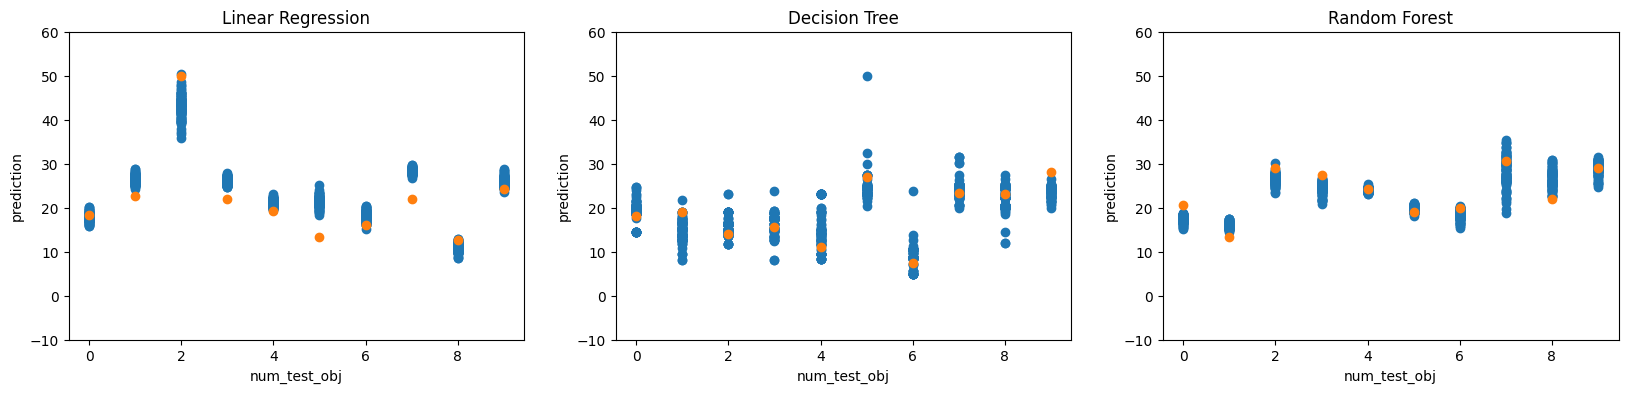

In [12]:
plt.figure(figsize=(20,4))
regressors = {'Linear Regression':LinearRegression(), 'Decision Tree': DecisionTreeRegressor(), 'Random Forest':RandomForestRegressor()}
for i, name in enumerate(regressors):
    plt.subplot(1, 3, i + 1)
    plot_predictions(regressors[name], X.to_numpy(), y.to_numpy(), title=name)

__7. (0.5 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ Получили всё то же самое, что и раньше:
- У линейной регрессии точки кучкуются, что говорит о низком variance, то правильный ответ лежит далеко не в центре, то есть большой bias
- У решающего дерева точки немного разбросаны, то есть variance тут больше, то правильный ответ лежит почти в центре кучки, то есть bias низкий
- Случайный лес решает проблему предыдущих алгоритмов и имеет и низкий variance(точки кучкуются), и низкий bias(правильный ответ близок к центру)

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

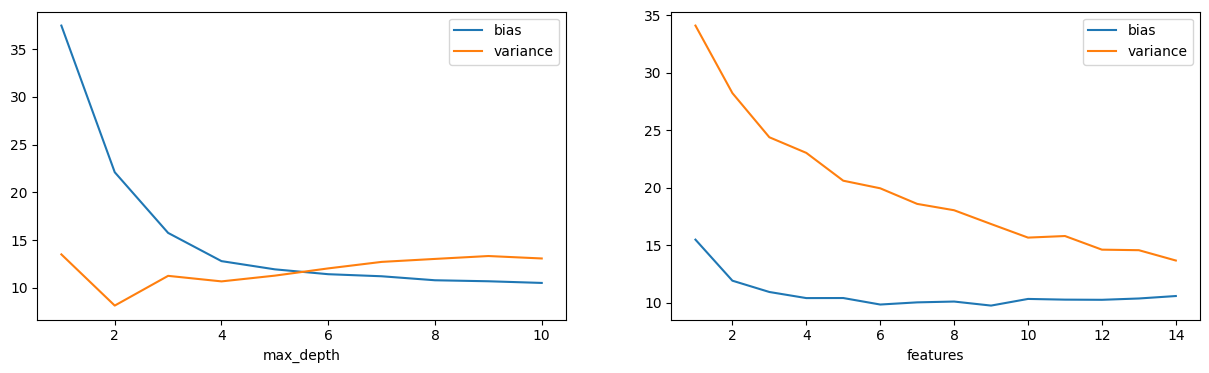

In [13]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
biases, variances = [], []
for max_depth in range(1, 11):
    bias, variance, _ = compute_biase_variance(DecisionTreeRegressor(max_depth=max_depth), X.to_numpy(), y.to_numpy())
    biases.append(bias)
    variances.append(variance)
plt.plot(range(1, 11), biases, label='bias')
plt.plot(range(1, 11), variances, label='variance')
plt.legend()
plt.xlabel('max_depth')
plt.subplot(1,2,2)
biases, variances = [], []
for features in range(1, X.shape[1] + 1):
    bias, variance, _ = compute_biase_variance(DecisionTreeRegressor(max_features=features), X.to_numpy(), y.to_numpy())
    biases.append(bias)
    variances.append(variance)
plt.plot(range(1, X.shape[1] + 1), biases, label='bias')
plt.plot(range(1, X.shape[1] + 1), variances, label='variance')
plt.legend()
plt.xlabel('features')
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

100%|██████████| 9/9 [08:41<00:00, 57.92s/it] 


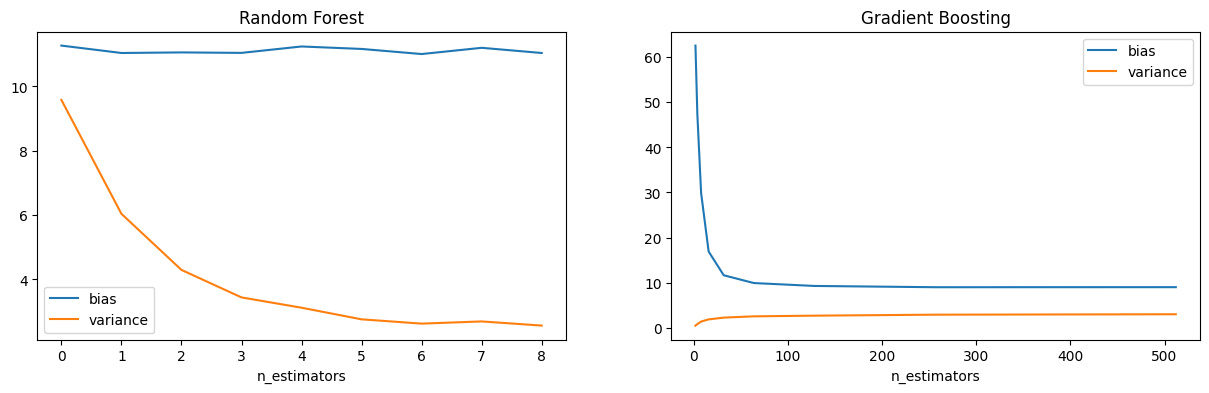

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
from tqdm import tqdm

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
biases, variances = [], []
for n_estimators in tqdm(2 ** np.arange(1,10)):
    bias, variance, _ = compute_biase_variance(RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1), X.to_numpy(), y.to_numpy())
    biases.append(bias)
    variances.append(variance)
plt.plot(biases, label='bias')
plt.plot(variances, label='variance')
plt.legend()
plt.xlabel('n_estimators')
plt.title('Random Forest')
plt.subplot(1,2,2)
biases, variances = [], []
for n_estimators in tqdm(2 ** np.arange(1,10)):
    bias, variance, _ = compute_biase_variance(GradientBoostingRegressor(n_estimators=n_estimators), X.to_numpy(), y.to_numpy())
    biases.append(bias)
    variances.append(variance)
plt.plot((2 ** np.arange(1,10)), biases, label='bias')
plt.plot((2 ** np.arange(1,10)), variances, label='variance')
plt.legend()
plt.xlabel('n_estimators')
plt.title('Gradient Boosting')
plt.show()

__10. (1.5 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

1. Зависимость разброса и смещения от глубины: смещение сначала резко падает, потому что, увеличивая глубину дерева, мы помогаем ему лучше обучится, далее смещение убывает всё медленнее и медленнее, потому что деревья получают всю нужную информацию; разброс начала падает, потому что деревья необученные, а дальше они начинают переобучаться и разброс начинает расти(всё согласуется с теорией)

2. Зависимость разброса и смещения от количество фичей: могу предположить, что разброс убывает, потому что чем больше фичей, тем проще делить выборку, потому что мы чаще будет находить реально круто признак; смещение же сначала падает, потому что дерево лучше обучается, а дальше оно почти не меняется, могу лишь предположить, что, как и в прошлом пункте, с какого-то момента увеличение фичей не даёт сильного буста

3. Зависимость разброса и смещения от количество деревьев в лесу: смещение почти константное, потому что у всех деревьев почти одно и то же смещение, а лес ни как не понижает его; разброс же сначала падает, так как появляются новые несильно скореллированные деревья, а далее увеличение числа этих деревьев уже не слишком понижает разброс, потому что деревья становятся скореллированными

4. Зависимость разброса и смещения от количество деревьев в GBM: смещение сначала падает, потому что мы каждое следующее дерево учится на ошибках предыдущего, но в какой-то момент бустинг уже настолько обучился, что следующие деревья не дают сильного буста; смещение же понемного растёт, потому что бустинг можно переобучить, но как видно, для этого нужно взять немало деревьев(а смысл, если мы и так уже хорошо обучились?)

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__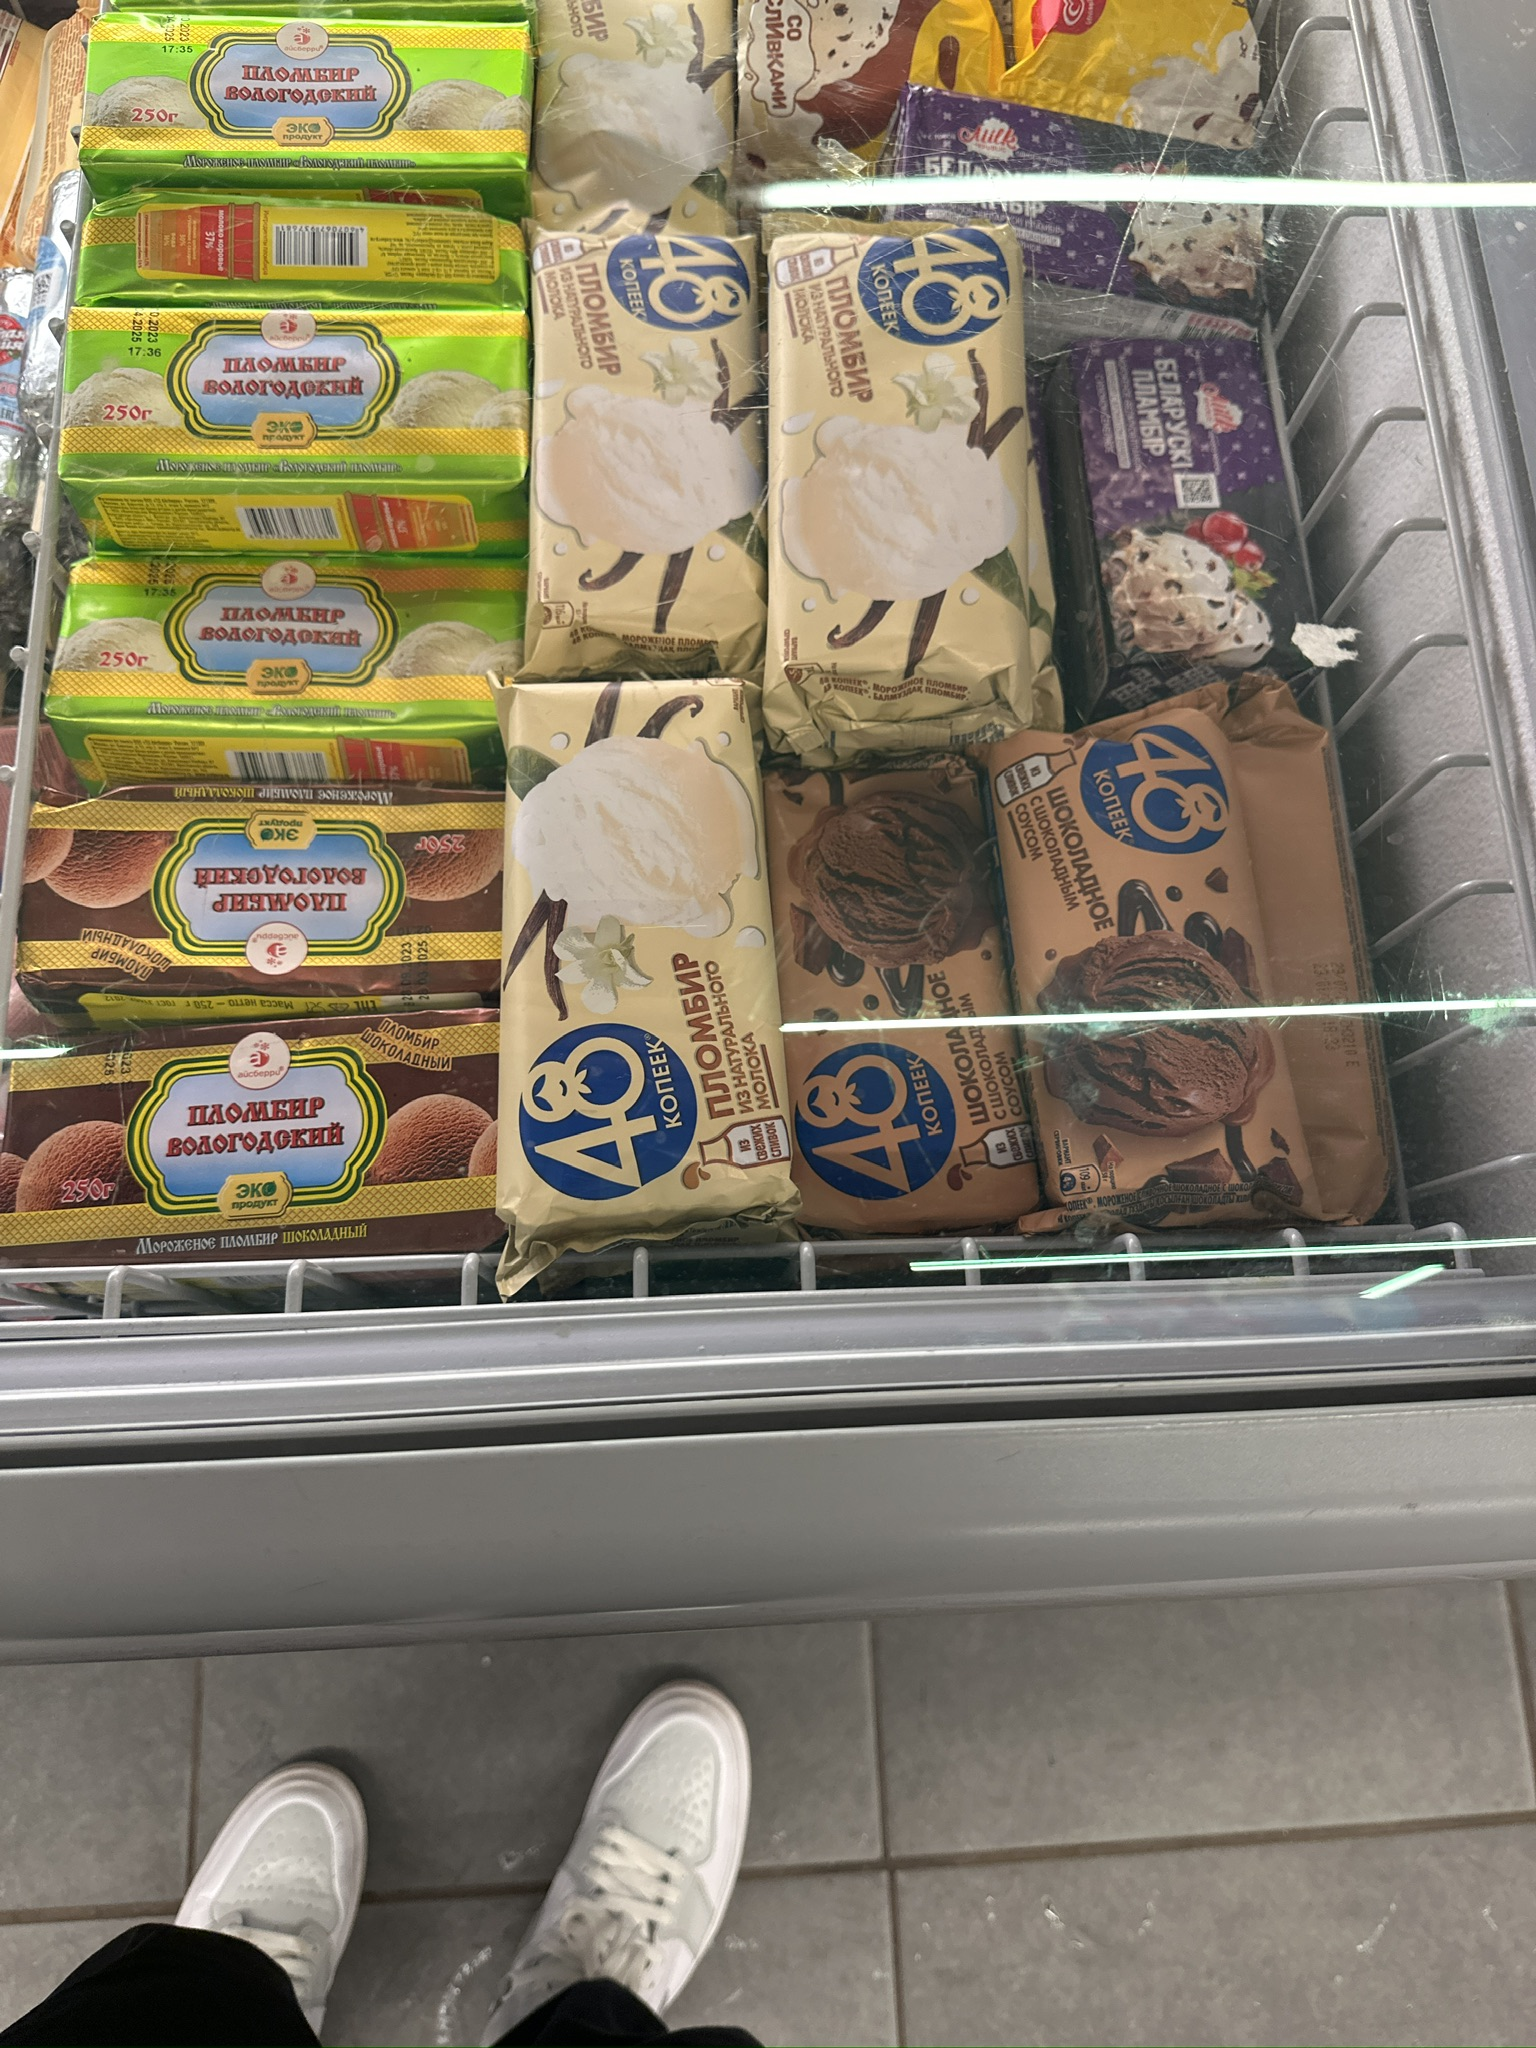